In [1]:
### import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from importlib import reload

In [2]:
import depthutil as dpu
reload(dpu)

<module 'depthutil' from '/Users/gliao/Documents/marketdepthstudy/depthutil.py'>

In [8]:
# recalculating takes a long time!
recalculate=0
if(recalculate):
    dp,ld,lr=dpu.CalcAll(filein='data/mintburn_usdceth3000_220202.csv',fileprice='data/ethprice_latest.csv', tickspacing=60,depthpct=0.02)
    dp.to_pickle('data/depth_usdceth_3000_latest.pkl')
    ld.to_pickle('data/liqdistr_usdceth_3000_latest.pkl')
    lr.to_pickle('data/liqrange_usdceth_3000_latest.pkl')
else:
    # Liquidity range with liquidity amount at every tic
    lr=pd.read_pickle('data/liqrange_usdceth_3000_latest.pkl')
    # liquidity distribution with liquidity expressed in usd and depth
    ld=pd.read_pickle('data/liqdistr_usdceth_3000_latest.pkl')
    # depth (2%) time series
    dp=pd.read_pickle('data/depth_usdceth_3000_latest.pkl')

In [9]:
dfprice=pd.read_csv('data/ethprice_latest.csv').rename(columns={'price':'P'})
dfprice['date']=pd.to_datetime(dfprice.date).dt.date

<AxesSubplot:xlabel='price'>

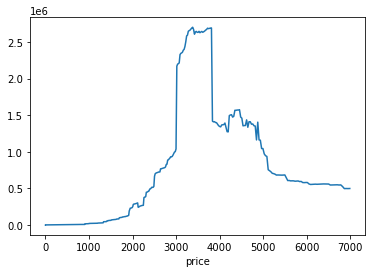

In [11]:
ld.loc[ld.price<7000].query('date=="2022-01-15"').set_index('price').liqX.plot()

In [12]:
ld.query('date=="2021-12-15"').set_index('price').liqX.sum()/1e6

4.777800531749009e+22

<AxesSubplot:xlabel='price'>

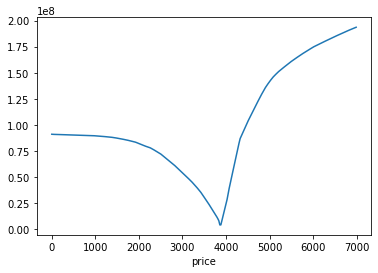

In [13]:
ld.loc[ld.price<7000].query('date=="2021-12-15"').set_index('price').depth.plot()

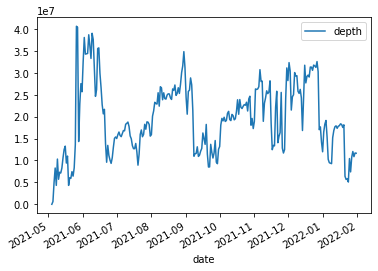

In [78]:
dp.query("date>='2021-05-01' & date<='2022-01-31'").plot('date','depth')
plt.savefig('output/HistoricalDepth.pdf')


In [17]:
cumdepth=pd.DataFrame(ld.query("date=='2021-12-15'").set_index('price').sort_index().liqX.cumsum()/ld.query("date=='2021-12-15'").liqX.sum())

Text(0.5, 1.0, 'Cummulative Liquidity across price range for USDC/ETH30')

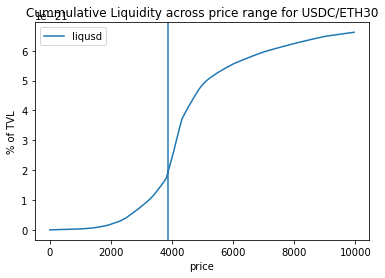

In [18]:
ax=cumdepth.loc[:10000].plot()
plt.axvline(3857.78)
ax.set_ylabel("% of TVL")
ax.set_title('Cummulative Liquidity across price range for USDC/ETH30')

In [ ]:
filein='data/mintburn_usdceth3000_simple.csv'
fileprice='data/ethprice.csv'
tickspacing=60
depthpct=0.02

#load data and format
dfprice=pd.read_csv(fileprice).rename(columns={'price':'P'})
dfprice['date']=pd.to_datetime(dfprice.date).dt.date
df=pd.read_csv(filein)
# df=pd.read_csv('data/mintburn_usdceth500.csv')
df['amount']=df.amount.map(float)
df=df.rename(columns={'lowertick':'tickLower','uppertick':'tickUpper'})
df['date']=pd.to_datetime(df.call_block_time).dt.date

dfs=df.groupby(['date','tickLower','tickUpper']).amount.sum()
dft2=pd.DataFrame(dfs).reset_index()

rgn=dpu.genLiqRange(dft2,tickspacing=tickspacing)

rgn['P']=dfprice.loc[dfprice.date==dft2.date.max(),'P'].values[0]

liq=dpu.genLiqRangeXNumeraire(rgn,tickspacing=tickspacing).pipe(dpu.calcDepth)
# liq2=dpu.genLiqRangeXNumeraire(rgn,tickspacing=tickspacing,alt=1).pipe(dpu.calcDepth)

# pd.merge(liq,liq2,on='price').query('price<10000').set_index('price')[['liqX_x','liqX_y']].plot()

# Comparison with Coinbase (data from Kaiko)

In [25]:
reloadkaiko=0

In [26]:
if reloadkaiko:
    import kaiko
    kc = kaiko.KaikoClient(api_key='')
    pairs=['eth-usd','eth-usdt','eth-usdc','eth-dai']
    cbse=dict()
    for pair in pairs:
        tmp=kaiko.OrderBookAggregations('cbse',instrument=pair,interval='1d',start_time='2022-01-01',client=kc)
        cbse[pair]=tmp.df
    dfcbse=pd.concat(cbse)
    dfcbse.to_pickle('data/kaiko_coinbase_220202.pkl')
else:
    dfcbse=pd.read_pickle('data/kaiko_exchanges_eth_220202.pkl')

In [31]:
dfcb=pd.DataFrame(dfcbse.loc['cbse'].loc['eth-usd',['bid_volume2','ask_volume2']].sum(axis=1)).reset_index()
dfcb.columns=['date','depth_coinbase_eth']

In [32]:
dfprice['date']=pd.to_datetime(dfprice.date)
dfcb2=pd.merge(dfcb,dfprice,on='date')
dfcb2['depth_coinbase']=dfcb2.P*dfcb2.depth_coinbase_eth
dfm=pd.merge(dp,dfcb2[['date','depth_coinbase','P']],on='date')

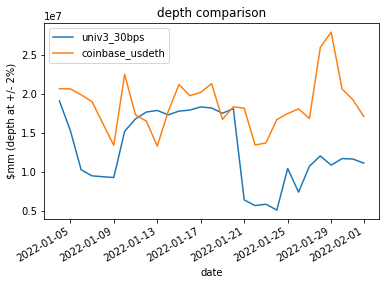

In [33]:
ax=dfm.set_index('date')[['depth','depth_coinbase']].rename(columns={'depth':'univ3_30bps','depth_coinbase':'coinbase_usdeth'}).plot()
ax.set_ylabel('$mm (depth at +/- 2%)')
ax.set_title('depth comparison')
plt.savefig('output/depth_comparison_ts_220202.pdf')


/var/folders/tc/9dm505_x3d31m9kyjmcy53g80000gn/T/ipykernel_28636/1089338462.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "width" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('output/heatmap.pdf',width=10,height=6)
/var/folders/tc/9dm505_x3d31m9kyjmcy53g80000gn/T/ipykernel_28636/1089338462.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "height" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('output/heatmap.pdf',width=10,height=6)


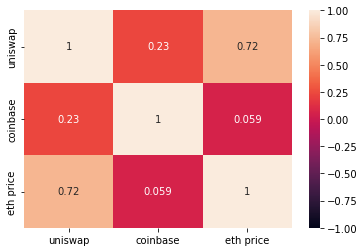

In [34]:
dfm2=dfm.set_index('date')[['depth','depth_coinbase','P']].rename(columns={'depth':'uniswap','P':'eth price',
                                                                           'depth_coinbase':'coinbase'})
heatmap = sns.heatmap(dfm2.corr(), vmin=-1, vmax=1, annot=True)
plt.savefig('output/heatmap.pdf',width=10,height=6)


# Market Depth Skew 

In [42]:
dfcb=pd.merge(dfprice,
              pd.DataFrame(dfcbse.loc['cbse'].loc['eth-usd',['bid_volume10','ask_volume10']].reset_index()).rename(
    columns={'index':'date',
            'bid_volume10':'coinbase10bid',
            'ask_volume10':'coinbase10ask'}),
              on='date')


In [43]:
dfcb['coinbasebid']=dfcb.P*dfcb.coinbase10bid
dfcb['coinbaseask']=dfcb.P*dfcb.coinbase10ask

In [44]:
dp10=dpu.fillGranularDistributionOverTime(ld,depthpct=.1,tickspacing=60)

In [45]:
dfbidask=pd.merge(dp10,dfcb,on='date')[['date','depthbid','depthask','coinbasebid','coinbaseask','P']].rename(columns={'depthbid':'v3depthbid',
                                                                                                                      'depthask':'v3depthask'})

<AxesSubplot:xlabel='date'>

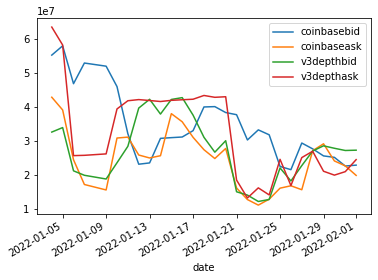

In [46]:
dfbidask.plot('date',['coinbasebid','coinbaseask','v3depthbid','v3depthask'])

/var/folders/tc/9dm505_x3d31m9kyjmcy53g80000gn/T/ipykernel_28636/1125535763.py:2: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "width" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('output/heatmap2.pdf',width=10,height=6)
/var/folders/tc/9dm505_x3d31m9kyjmcy53g80000gn/T/ipykernel_28636/1125535763.py:2: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "height" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('output/heatmap2.pdf',width=10,height=6)


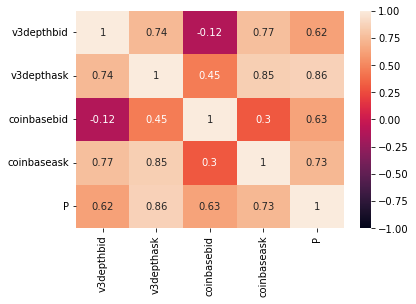

In [47]:

heatmap = sns.heatmap(dfbidask.corr(), vmin=-1, vmax=1, annot=True)
plt.savefig('output/heatmap2.pdf',width=10,height=6)


In [48]:
dfbidask['v3ratio_ab']=dfbidask.v3depthask/dfbidask.v3depthbid

dfbidask['cbratio_ab']=dfbidask.coinbaseask/dfbidask.coinbasebid

In [49]:
dfbidask.corr()

,v3depthbid,v3depthask,coinbasebid,coinbaseask,P,v3ratio_ab,cbratio_ab
v3depthbid,1.000000,0.737286,-0.117290,0.769997,0.618526,-0.042900,0.806706
v3depthask,0.737286,1.000000,0.448303,0.846405,0.859772,0.631909,0.360992
coinbasebid,-0.117290,0.448303,1.000000,0.299470,0.628846,0.813115,-0.522338
coinbaseask,0.769997,0.846405,0.299470,1.000000,0.727665,0.352563,0.626744
P,0.618526,0.859772,0.628846,0.727665,1.000000,0.585526,0.176960
v3ratio_ab,-0.042900,0.631909,0.813115,0.352563,0.585526,1.000000,-0.402058
cbratio_ab,0.806706,0.360992,-0.522338,0.626744,0.176960,-0.402058,1.000000


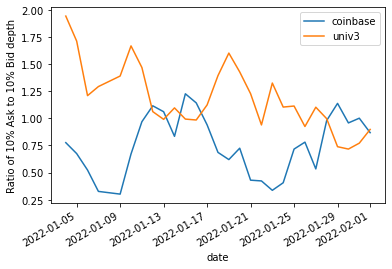

In [50]:
fig, ax = plt.subplots(1)
dfbidask.set_index('date')[['cbratio_ab','v3ratio_ab']].rename(columns={'cbratio_ab':'coinbase','v3ratio_ab':'univ3'}).plot(ax=ax)
# dfbidask.plot('date','P',ax=ax[1])
ax.set_ylabel('Ratio of 10% Ask to 10% Bid depth')
# ax[1].set_ylabel('Price of eth')
plt.savefig('output/MarketDepthSkew1_220202.pdf')

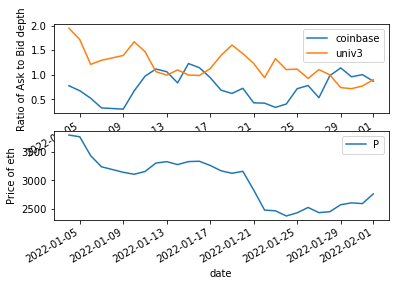

In [51]:
fig, ax = plt.subplots(2)
dfbidask.set_index('date')[['cbratio_ab','v3ratio_ab']].rename(columns={'cbratio_ab':'coinbase','v3ratio_ab':'univ3'}).plot(ax=ax[0])
dfbidask.plot('date','P',ax=ax[1])
ax[0].set_ylabel('Ratio of Ask to Bid depth')
ax[1].set_ylabel('Price of eth')

plt.savefig('output/MarketDepthSkew220202.pdf')

In [6]:
%qtconsole

### Multiple CEX comparison

In [52]:
with open('kaikoapikey.txt') as f:
    apikey = f.readlines()[0].replace('\n','')

In [53]:
reloadkaiko=0

In [70]:
if reloadkaiko:
    import kaiko
    kc = kaiko.KaikoClient(api_key=apikey)
    pairs=['eth-usd','eth-usdt','eth-usdc','eth-dai']
    exchanges=['cbse','bnce','bnus','krkn','gmni','huob','usp2','usp3','ftxu','ftxx']
    # exchanges=['cbse']
    oball=dict()
    for exchange in exchanges:
        ob=dict()
        for pair in pairs:
            tmp=kaiko.OrderBookAggregations(exchange,instrument=pair,interval='1d',start_time='2021-12-19',client=kc)
            ob[pair]=tmp.df
        dfob=pd.concat(ob)
        dfob['exchange']=exchange
        oball[exchange]=dfob
    df=pd.concat(oball)
    df.to_pickle('data/kaiko_exchanges_eth_20220118.pkl')
else:
    df=pd.read_pickle('data/kaiko_exchanges_eth_220202.pkl')

In [71]:
df=df[['bid_volume2','ask_volume2']].reset_index()
df.columns=['exch','pair','date','bid','ask']
df1=df.query("date<='2022-02-01'")
dfprice['date']=pd.to_datetime(dfprice.date)
df2=pd.merge(df1,dfprice,on='date')
df2['depth_bid']=df2.bid*df2.P
df2['depth_ask']=df2.ask*df2.P
depthall=pd.DataFrame(df2.groupby(['exch','pair'])[['depth_bid','depth_ask']].mean().sum(axis=1))
depthall2=depthall.reset_index()
depthall2['label']=depthall2.exch+'_'+depthall2.pair
dpa=depthall2.rename(columns={0:'depth'})


In [73]:
dfcomp=pd.concat([dpa.sort_values('depth',ascending=False)[:5],
           pd.DataFrame({'exch':'univ3','pair':'eth-usdc','depth':dfm.query('date>="2021-12-01" & date<="2021-12-15"').depth.mean(),'label':'univ3-eth-usdc'},index=[99])])

In [74]:
dfcomp=pd.concat([dpa.sort_values('depth',ascending=False)[:5],
           pd.DataFrame({'exch':'univ3','pair':'eth-usdc','depth':dfm.query('date>="2022-01-01" & date<="2022-02-01"').depth.mean(),'label':'univ3-eth-usdc'},index=[99])])

/Users/gliao/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exch', ylabel='depth'>

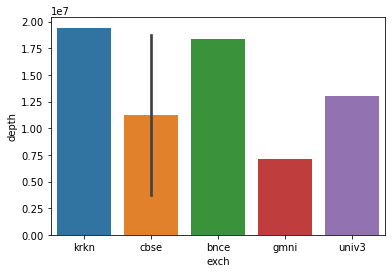

In [77]:
sns.barplot(dfcomp.exch,dfcomp.depth)